In [850]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import sklearn
import math
import seaborn as sb
import xgboost as xgb
from bisect import bisect_left
from sklearn.metrics import accuracy_score
from IPython.display import display, Math, Latex
from matplotlib.legend_handler import HandlerLine2D
from collections import Counter
from sklearn import datasets, linear_model, cross_validation, datasets, grid_search,  metrics, preprocessing
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn import ensemble
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
%matplotlib inline

Прежде, чем выбирать и тренировать модели, я решил поискать, что известно по этой теме:
<br>https://www.ruor.uottawa.ca/bitstream/10393/31553/3/Weissbock_Joshua_2014_thesis.pdf
<br>http://web.uvic.ca/~afyshe/dm_projs/nhl_final_report.pdf
<br>http://thesportjournal.org/article/goal-based-metrics-better-than-shot-based-metrics-at-predicting-hockey-success/

В целом, как я понял, модели основанные на подсчёте голов работают намного лучше, чем модели, основанные на подсчёте бросков по воротам.
<br>В файле очень стрёмные данные, возможно, я их обрабатываю не совсем эффективно, но мне ещё не приходилось тратить столько время на предобработку до обучения моделей :)

In [2]:
data2013_2014 = pd.read_csv("data2013-2014.csv")

/home/rtriangle/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,57) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data2013_2014.describe()

/home/rtriangle/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Unnamed: 0,Duration,Game.ID,Seconds,Home.Skaters,Away.Skaters,Home.Score,Away.Score,Score.Cat,Event.Length,...,fweight1,sweight1,gweight1,cweight2,fweight2,sweight2,gweight2,is.Rebound,is.Rush,xG
count,2.526505e+06,2.108858e+06,2.526447e+06,2.526505e+06,2.526505e+06,2.526505e+06,2.526505e+06,2.526505e+06,2.526505e+06,2.526505e+06,...,2.526505e+06,2.526505e+06,2.526505e+06,2.526505e+06,2.526505e+06,2.526505e+06,2.526505e+06,2.526505e+06,2.526505e+06,112062.000000
mean,1.263253e+06,5.402609e+01,2.136209e+04,1.824997e+03,4.794811e+00,4.795009e+00,1.338297e+00,1.193619e+00,1.339206e-01,1.921711e+00,...,1.053428e+00,1.048019e+00,1.048531e+00,1.007583e+00,1.005990e+00,1.005763e+00,1.002349e+00,2.442109e-03,2.843850e-03,0.063799
std,7.293393e+05,9.878570e+01,2.592268e+03,1.080966e+03,7.438128e-01,7.241270e-01,1.369353e+00,1.286519e+00,1.374058e+00,5.043676e+00,...,2.665875e-01,2.468885e-01,2.424413e-01,8.744871e-02,7.730224e-02,7.578931e-02,4.758263e-02,4.935733e-02,5.325188e-02,0.066184
min,1.000000e+00,-1.200000e+03,2.000100e+04,-1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00,-1.000000e-03,...,6.247371e-01,6.328879e-01,6.514085e-01,8.370780e-01,8.505145e-01,8.488780e-01,9.337780e-01,0.000000e+00,0.000000e+00,0.003730
25%,6.316270e+05,NaN,NaN,8.910010e+02,5.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,...,9.012834e-01,9.046361e-01,9.273743e-01,9.616500e-01,9.602225e-01,9.635553e-01,9.453376e-01,0.000000e+00,0.000000e+00,NaN
50%,1.263253e+06,NaN,NaN,1.815001e+03,5.000000e+00,5.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,NaN
75%,1.894879e+06,NaN,NaN,2.745999e+03,5.000000e+00,5.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,9.000000e-03,...,1.123001e+00,1.117839e+00,1.084967e+00,1.041536e+00,1.043215e+00,1.039310e+00,1.061372e+00,0.000000e+00,0.000000e+00,NaN
max,2.526505e+06,1.200000e+03,3.041500e+04,6.026000e+03,6.000000e+00,6.000000e+00,9.000000e+00,8.000000e+00,3.000000e+00,8.099000e+01,...,2.504215e+00,2.381285e+00,2.151163e+00,1.241668e+00,1.213237e+00,1.216583e+00,1.076332e+00,1.000000e+00,1.000000e+00,0.535407


In [5]:
data2013_2014.columns

Index([u'Unnamed: 0', u'Period', u'Event', u'Description', u'Duration',
       u'Date', u'Game.ID', u'ev.team', u'p1', u'p2', u'p3', u'ev.zone',
       u'Detail', u'Seconds', u'a1.num', u'a1.pos', u'a2.num', u'a2.pos',
       u'a3.num', u'a3.pos', u'a4.num', u'a4.pos', u'a5.num', u'a5.pos',
       u'a6.num', u'a6.pos', u'h1.num', u'h1.pos', u'h2.num', u'h2.pos',
       u'h3.num', u'h3.pos', u'h4.num', u'h4.pos', u'h5.num', u'h5.pos',
       u'h6.num', u'h6.pos', u'Away.Team', u'Home.Team', u'Away.Goalie',
       u'Home.Goalie', u'Home.Skaters', u'Away.Skaters', u'Home.Score',
       u'Away.Score', u'Strength.State', u'Score.State', u'Score.Cat',
       u'Event.Length', u'URL', u'Highlight', u'XC', u'YC', u'Season',
       u'Season.Type', u'Home.Zone', u'Newcode', u'Round.Seconds', u'Distance',
       u'Angle', u'cweight1', u'fweight1', u'sweight1', u'gweight1',
       u'cweight2', u'fweight2', u'sweight2', u'gweight2', u'is.Rebound',
       u'is.Rush', u'xG'],
      dtype='object')

Я решил выделить признаки, несущие наибольшее количество информации для моей задачи, с помощью них можно будет сгенерировать также много новых фич.

In [6]:
data2013_2014_useful = data2013_2014[["Period", "Game.ID", "Away.Team", "Home.Team", 
                                      "Home.Score", "Away.Score", "Season", "Season.Type", 
                                      "Strength.State", "Score.State"]]

In [7]:
print data2013_2014_useful.shape
print Counter(np.array(data2013_2014_useful["Season"]))

(2526505, 10)
Counter({20132014: 2526505})


In [8]:
print data2013_2014_useful.shape
print Counter(np.array(data2013_2014_useful["Season.Type"]))

(2526505, 10)
Counter({'Regular': 2330144, 'Playoffs': 196361})


Таким образом, можем удалить колонку "Season", а из "Season.Type" сделать в будущем новый признак isRegular и isPlayOff

In [9]:
print Counter(data2013_2014_useful["Period"])

Counter({'1': 572493, '3': 556499, '2': 532299, 1: 284185, 3: 270162, 2: 263560, 'OT': 28376, 4: 7995, '4': 6900, '5': 2544, 5: 1460, 6: 30, nan: 2})


Правила об овертаймах в нхл меняются чуть ли не каждый год, но, в любом случае, давайте считать, что 1, 2, 3 - это основные периоды, а всё остальное - это 4ый период, то есть, овертайм.

In [10]:
di = {'1': 1, '2': 2, '3': 3, '4': 4, '5': 4, '6': 4, 'OT': 4, 5: 4, 6: 4, np.nan: 4}

In [11]:
data2013_2014_useful = data2013_2014_useful.replace({"Period": di})

In [12]:
print Counter(data2013_2014_useful["Period"])
print Counter(data2013_2014_useful["Season"])

Counter({1: 856678, 3: 826661, 2: 795859, 4: 47307})
Counter({20132014: 2526505})


Cезон тоже можно удалить, потому что он не несёт никакой информации

In [13]:
del data2013_2014_useful["Season"]

Также видим, что Home.Score и Away.Score содержат ту же информацию, что и Score.State, поэтому удалим Score.State

In [14]:
del data2013_2014_useful["Score.State"]

Добавим признак isRegular, который будет = 1, если это регулярный чемпионат и -1, если это плей-офф. 
<br> На мой взгляд, это лучше, чем добавить 2 признака isRegular и isPlayoff, с 1 и 0 в соответствующих ячейках, так как тогда эти 2 признака будут сильно коррелировать и веса будут большими, если мы будем использовать модели без регуляризаторов.

In [15]:
data2013_2014_useful['isRegular'] = np.where(data2013_2014_useful['Season.Type']=='Regular', 1, -1)
del data2013_2014_useful['Season.Type']

In [16]:
data2013_2014_useful.head()

,Period,Game.ID,Away.Team,Home.Team,Home.Score,Away.Score,Strength.State,isRegular
0,1,20001.0,TOR,MTL,0,0,5v5,1
1,1,20001.0,TOR,MTL,0,0,5v5,1
2,1,20001.0,TOR,MTL,0,0,5v5,1
3,1,20001.0,TOR,MTL,0,0,5v5,1
4,1,20001.0,TOR,MTL,0,0,5v5,1


In [17]:
x = np.array(data2013_2014_useful["Strength.State"])
x1 = map(lambda y: (y.split('v')[0]), x)
x2 = map(lambda y: (y.split('v')[1]), x)

In [18]:
print Counter(x1)
print Counter(x2)

Counter({'5': 2166283, '4': 275918, 'E': 74032, '3': 6099, '0': 4055, '2': 63, '1': 55})
Counter({'5': 2151834, '4': 289256, 'E': 74032, '3': 7693, '0': 3651, '1': 24, '2': 15})


Я не знаю, что значит E в Strength.State, возможно, это equal, но в первых строчках видно, что в случае равных составов всё равно пишут XvX. Этих данных не так уж много по сравнению с числами, поэтому в будущем можем выкинуть строчки, где есть E

In [19]:
x1 = map(lambda x: float(x) if x != 'E' else 'E', x1)
x2 = map(lambda x: float(x) if x != 'E' else 'E', x2)

In [20]:
print Counter(x1)
print Counter(x2)

Counter({5.0: 2166283, 4.0: 275918, 'E': 74032, 3.0: 6099, 0.0: 4055, 2.0: 63, 1.0: 55})
Counter({5.0: 2151834, 4.0: 289256, 'E': 74032, 3.0: 7693, 0.0: 3651, 1.0: 24, 2.0: 15})


In [21]:
data2013_2014_useful["Away.Team.Strength"] = np.array(x1)
data2013_2014_useful["Home.Team.Strength"] = np.array(x2)

In [22]:
del data2013_2014_useful["Strength.State"]

In [23]:
data2013_2014_useful.shape

(2526505, 9)

In [24]:
data2013_2014_useful = data2013_2014_useful[data2013_2014_useful["Away.Team.Strength"] != 'E']
data2013_2014_useful = data2013_2014_useful[data2013_2014_useful["Home.Team.Strength"] != 'E']

In [25]:
data2013_2014_useful.shape

(2452473, 9)

Добавим информацию об удалениях, чтобы потом можно было считать количество удалений в периоде/матче и тд

In [26]:
x1 = list(data2013_2014_useful["Away.Team.Strength"])
x2 = list(data2013_2014_useful["Home.Team.Strength"])

In [27]:
x1 = map(lambda x: float(x), x1)
x2 = map(lambda x: float(x), x2)

In [28]:
x1_penalty = [float(max(x1[i] - x1[i+1], 0)) for i in range(len(x1)-1)] 
x2_penalty = [float(max(x2[i] - x2[i+1], 0)) for i in range(len(x2)-1)]
print np.sum(x1_penalty)
print np.sum(x2_penalty)

17497.0
18427.0


In [29]:
len(x1_penalty)

2452472

In [30]:
x1_penalty = x1_penalty + [0]
x2_penalty = x2_penalty + [0]

Так как уменьшили размерность на 1

In [31]:
data2013_2014_useful["Away.Penalty"] = np.array(x1_penalty)
data2013_2014_useful["Home.Penalty"] = np.array(x2_penalty)

Посмотрим на названия всех команд:

In [32]:
teams = list(set(np.array(data2013_2014_useful["Away.Team"])))
print teams

['N.J', 'MIN', 'TOR', 'WSH', 'BOS', 'DET', 'NYI', 'FLA', 'L.A', 'COL', 'NSH', 'DAL', 'CGY', 'NYR', 'CAR', 'WPG', 'BUF', 'VAN', 'STL', 'CHI', 'T.B', 'S.J', 'MTL', 'PHI', 'ANA', 'CBJ', 'PIT', 'EDM', 'ARI', 'OTT']


In [33]:
data2013_2014_useful.head()

,Period,Game.ID,Away.Team,Home.Team,Home.Score,Away.Score,isRegular,Away.Team.Strength,Home.Team.Strength,Away.Penalty,Home.Penalty
0,1,20001.0,TOR,MTL,0,0,1,5.0,5.0,0.0,0.0
1,1,20001.0,TOR,MTL,0,0,1,5.0,5.0,0.0,0.0
2,1,20001.0,TOR,MTL,0,0,1,5.0,5.0,0.0,0.0
3,1,20001.0,TOR,MTL,0,0,1,5.0,5.0,0.0,0.0
4,1,20001.0,TOR,MTL,0,0,1,5.0,5.0,0.0,0.0


In [34]:
data2013_2014_useful.shape

(2452473, 11)

Я заметил, что есть nan в Game.ID, тяжело будет работать с такими данными, удалим их

In [35]:
data2013_2014_useful = data2013_2014_useful[np.isfinite(data2013_2014_useful["Game.ID"])]

In [85]:
data2013_2014_useful.shape

(2452416, 11)

In [86]:
keys_of_data_Home = data2013_2014_useful.groupby(['Home.Team', 'Game.ID']).groups.keys()
keys_of_data_Away = data2013_2014_useful.groupby(['Away.Team', 'Game.ID']).groups.keys()

In [87]:
keys_of_data_Home.sort()
keys_of_data_Away.sort()

In [124]:
gamesid_for_team = dict()
for team in teams:
    gamesid_for_team[team] = list()

In [125]:
for line in keys_of_data_Home:
    gamesid_for_team[line[0]].append(line[1])
for line in keys_of_data_Away:
    gamesid_for_team[line[0]].append(line[1])

Получили полезный набор Games.ID для каждой команды

In [41]:
game_ids = data2013_2014_useful.groupby(['Game.ID']).groups.keys()
game_ids.sort()

In [42]:
data2013_2014_useful['Away.Team.Strength'] = data2013_2014_useful['Away.Team.Strength'].astype('float64')
data2013_2014_useful['Home.Team.Strength'] = data2013_2014_useful['Home.Team.Strength'].astype('float64')

In [43]:
data2013_2014_useful_grouped_Games = data2013_2014_useful.groupby(['Game.ID']).max()
data2013_2014_useful_grouped_Games_sum = data2013_2014_useful.groupby(['Game.ID']).sum()
data2013_2014_useful_grouped_Games_mean = data2013_2014_useful.groupby(['Game.ID']).mean()

In [44]:
data2013_2014_useful_grouped_Games["Away.Penalty"] = data2013_2014_useful_grouped_Games_sum["Away.Penalty"]
data2013_2014_useful_grouped_Games["Home.Penalty"] = data2013_2014_useful_grouped_Games_sum["Home.Penalty"]
data2013_2014_useful_grouped_Games["Home.Team.Strength"] = data2013_2014_useful_grouped_Games_mean["Home.Team.Strength"]
data2013_2014_useful_grouped_Games["Away.Team.Strength"] = data2013_2014_useful_grouped_Games_mean["Away.Team.Strength"]

In [45]:
data2013_2014_useful_grouped_Games.head()

,Period,Away.Team,Home.Team,Home.Score,Away.Score,isRegular,Away.Team.Strength,Home.Team.Strength,Away.Penalty,Home.Penalty
Game.ID,,,,,,,,,,
20001.0,3,TOR,MTL,3,4,1,4.769272,4.857143,27.0,23.0
20002.0,3,WSH,CHI,6,4,1,4.859194,4.877416,16.0,18.0
20003.0,3,WPG,EDM,4,5,1,4.837090,4.876025,19.0,14.0
20004.0,3,TOR,PHI,1,3,1,4.917208,4.813312,17.0,23.0
20005.0,3,BUF,DET,2,1,1,4.804692,4.875713,29.0,9.0


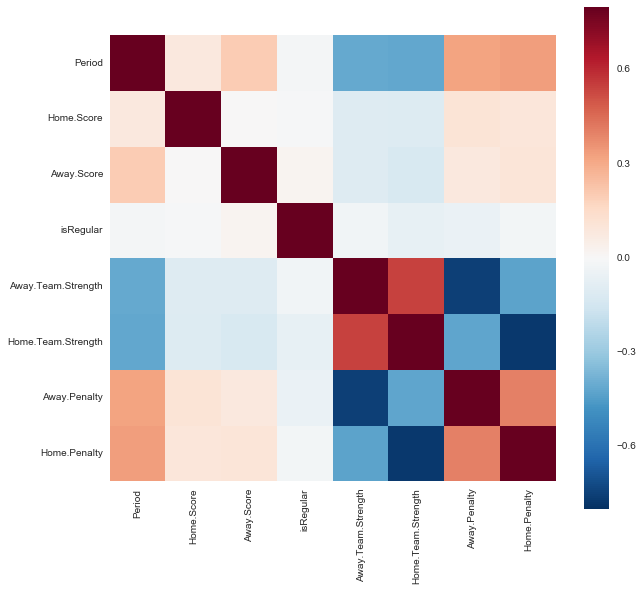

In [46]:
corr = data2013_2014_useful_grouped_Games.corr()
f, ax = plt.subplots(figsize=(10, 9))
sb.heatmap(corr, vmax=.8, square=True)
plt.show()

Видим, что Penalty кореллирует с периодом, это можно объяснить тем, что в овертаймах команды играют 4v4.
Также Penalty кореллирует с Team.Strength, что тоже понятно из того, что оба признака описывают количество штрафов за игру. Home.Team.Strength и Away.Team.Strength коррелируют тоже из-за овертаймов. Если будут проблемы, то в будущем удалим сильно кореллирующие)

Давайте ещё немного посмотрим на данные :)

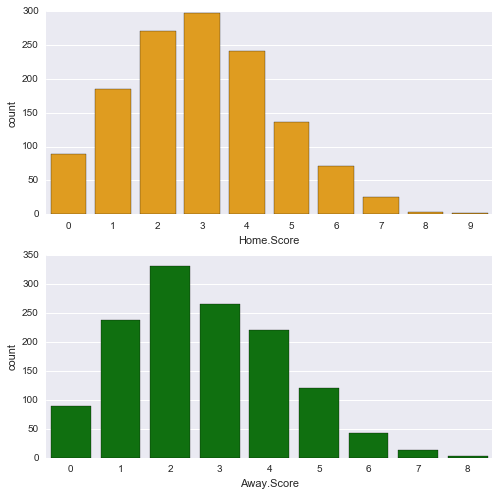

In [47]:
f, (ax1, ax2) = plt.subplots(2)
f.set_figheight(8)
f.set_figwidth(8)
sb.countplot(data2013_2014_useful_grouped_Games["Home.Score"], ax=ax1, color="orange")
sb.countplot(data2013_2014_useful_grouped_Games["Away.Score"], ax=ax2, color="green")
plt.show()

Достаточно логично, что команды в среднем дома играют лучше и забивают больше.

Теперь будем создавать матрицу, на которой будем тренировать модели.
Будем выбирать id матча, который хотим предсказать, затем искать 5 матчей до этого у каждой из 2-х играющих сейчас команд, а затем добавлять различные статистики в наш датафрейм.

In [48]:
data2013_2014_useful_grouped_Games_matrix = data2013_2014_useful_grouped_Games.as_matrix()
game_ids = np.array(game_ids)
print data2013_2014_useful_grouped_Games_matrix
print data2013_2014_useful_grouped_Games.shape
print game_ids.shape

[[3 'TOR' 'MTL' ..., 4.857142857142857 27.0 23.0]
 [3 'WSH' 'CHI' ..., 4.8774157923799 16.0 18.0]
 [3 'WPG' 'EDM' ..., 4.876024590163935 19.0 14.0]
 ..., 
 [3 'L.A' 'NYR' ..., 4.7753424657534245 10.0 19.0]
 [3 'L.A' 'NYR' ..., 4.913715710723192 3.0 23.0]
 [4 'NYR' 'L.A' ..., 4.9367127496159755 25.0 23.0]]
(1323, 10)
(1323,)


In [79]:
data2013_2014_useful_grouped_Games.head()

,Period,Away.Team,Home.Team,Home.Score,Away.Score,isRegular,Away.Team.Strength,Home.Team.Strength,Away.Penalty,Home.Penalty
Game.ID,,,,,,,,,,
20001.0,3,TOR,MTL,3,4,1,4.769272,4.857143,27.0,23.0
20002.0,3,WSH,CHI,6,4,1,4.859194,4.877416,16.0,18.0
20003.0,3,WPG,EDM,4,5,1,4.837090,4.876025,19.0,14.0
20004.0,3,TOR,PHI,1,3,1,4.917208,4.813312,17.0,23.0
20005.0,3,BUF,DET,2,1,1,4.804692,4.875713,29.0,9.0


Создавая новую матрицу, будем брать разные признаки в случаях, если команда играла дома и в гостях.

При добавлении новых признаков, можно всего лишь поменять 2 маски и 2 индекса:)

In [208]:
home_mask = np.array([0, 3, 5, 7, 9])
away_mask = np.array([0, 4, 5, 6, 8])

In [162]:
ind_of_home_score = 3
ind_of_away_score = 4

In [226]:
dataframe_for_predictions5 = []

In [164]:
for key in gamesid_for_team.keys():
    gamesid_for_team[key].sort()

Создадим словарь, где для каждого id будем получать номер строки в data2013_2014_useful_grouped_Games_matrix с таким Game.ID

In [165]:
place_of_game_with_id = dict()
for i in range(len(game_ids)):
    place_of_game_with_id[game_ids[i]] = i

Будем проходить по всем играм каждой команды, понимать, с кем она играла в матче с таким id, собирать статистику о 5 прошлых матчах этой команды и 5 прошлых матчах её текущего противника в игре с id.

In [227]:
for number_of_game, gameid in enumerate(game_ids):
    
    first_team = data2013_2014_useful_grouped_Games_matrix[number_of_game][1]
    second_team = data2013_2014_useful_grouped_Games_matrix[number_of_game][2]
    pointer_first = bisect_left(gamesid_for_team[first_team], gameid)
    pointer_second = bisect_left(gamesid_for_team[second_team], gameid)
    
    if (pointer_first > 5 and pointer_second > 5):
        new_line = []
        first_statistic = []
        second_statistic = []
        first_scores = []
        second_scores = []
        for i in range(pointer_first-5, pointer_first):
            first_game_id = gamesid_for_team[first_team][i]
            first_line = data2013_2014_useful_grouped_Games_matrix[place_of_game_with_id[first_game_id]]
            if (first_team == first_line[2]):
                first_statistic.append(list(first_line.take(home_mask)))
                first_scores.append(first_line.take(ind_of_home_score))
            else:
                first_statistic.append(list(first_line.take(away_mask)))
                first_scores.append(first_line.take(ind_of_away_score))
        for j in range(pointer_second-5, pointer_second):
            second_game_id = gamesid_for_team[second_team][j]
            second_line = data2013_2014_useful_grouped_Games_matrix[place_of_game_with_id[second_game_id]]
            if (second_team == second_line[2]):
                second_statistic.append(list(second_line.take(home_mask)))
                second_scores.append(second_line.take(ind_of_home_score))
            else:
                second_statistic.append(list(second_line.take(away_mask)))
                second_scores.append(second_line.take(ind_of_away_score))
                
        #print first_statistic
        #print second_statistic
        #print first_scores
        #print second_scores
        first_statistic = np.array(first_statistic)
        second_statistic = np.array(second_statistic)
        
        first_statistic_mean = first_statistic.mean(axis=0)
        second_statistic_mean = second_statistic.mean(axis=0)
        first_statistic_max = first_statistic.max(axis=0)
        second_statistic_max = second_statistic.max(axis=0)
        first_statistic_min = first_statistic.min(axis=0)
        second_statistic_min = second_statistic.min(axis=0)
        
        res = np.append(first_statistic_mean, [first_statistic_max, first_statistic_min,
                                               second_statistic_mean, second_statistic_max, 
                                               second_statistic_min])
        
        res = np.append(res, np.array([data2013_2014_useful_grouped_Games_matrix[number_of_game][3] \
                                       - data2013_2014_useful_grouped_Games_matrix[number_of_game][4]]))
        dataframe_for_predictions5.append(list(res))
        #print res.shape
        #print res
        #break

In [229]:
dataframe_for_predictions5 = np.array(dataframe_for_predictions5)

In [232]:
dataframe_for_predictions5.shape

(1226, 31)

In [428]:
dataframe_for_predictions5

array([[  3.2       ,   2.8       ,   1.        , ...,   4.74830547,
          5.        ,   3.        ],
       [  3.4       ,   3.2       ,   1.        , ...,   4.80898238,
         10.        ,  -1.        ],
       [  3.4       ,   2.6       ,   1.        , ...,   4.74247312,
          7.        ,  -3.        ],
       ..., 
       [  3.8       ,   4.        ,  -1.        , ...,   4.81323756,
         13.        ,  -3.        ],
       [  3.6       ,   3.8       ,  -1.        , ...,   4.77534247,
         13.        ,   1.        ],
       [  3.4       ,   1.8       ,  -1.        , ...,   4.86489014,
          3.        ,   1.        ]])

Давайте рассматривать различные регрессоры и подбирать для них оптимальные гиперпараметры.

In [830]:
X = dataframe_for_predictions5[:, 0:30]
X = preprocessing.normalize(X)
y = dataframe_for_predictions5[:, 30:31]
y = np.array(map(lambda x: x[0], y))
y_test = np.array(y[1000:1226])
y_train = np.array(y[0:1000])
X_test = np.array(X[1000:1226])
X_train = np.array(X[0:1000])
print X.shape
print y.shape
print y_test.shape
print y_train.shape

(1226, 30)
(1226,)
(226,)
(1000,)


In [831]:
def my_transformer(data):
    return [int(0.5 + np.sign(d) / 2.) for d in data]

In [972]:
y_test_bin = my_transformer(y_test)
y_train_bin = my_transformer(y_train)

In [973]:
print y_test_bin[:10]
print y_train_bin[:10]

[0, 0, 0, 1, 1, 1, 0, 1, 0, 1]
[1, 1, 0, 1, 1, 1, 0, 0, 0, 1]


In [939]:
print y
print X

[ 3. -1. -3. ..., -3.  1.  1.]
[1, 0, 0, 0, 1, 0, 1, 1, 0, 0]
[[ 0.06517161  0.05702516  0.02036613 ...,  0.02036613  0.0967046
   0.10183064]
 [ 0.06177386  0.0581401   0.01816878 ...,  0.01816878  0.08737336
   0.18168783]
 [ 0.09376647  0.07170377  0.02757837 ...,  0.02757837  0.13078969
   0.19304861]
 ..., 
 [ 0.09008066  0.09482175 -0.02370544 ..., -0.02370544  0.1140999
   0.30817069]
 [ 0.08681165  0.09163452 -0.02411435 ..., -0.02411435  0.11515427
   0.31348651]
 [ 0.07847547  0.04154584 -0.02308102 ..., -0.02308102  0.11228663
   0.06924306]]


In [989]:
accur = list()
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
    lassoreg = sklearn.linear_model.LassoLars(alpha=0.4)
    lassoreg.fit(X_train, y_train)
    res = lassoreg.predict(X_test)
    accur.append(metrics.accuracy_score(my_transformer(res), my_transformer(y_test)))
np.mean(accur)

0.53619021739130424

In [978]:
accur = list()
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
    ridgereg = sklearn.linear_model.Ridge(alpha=0.5)
    ridgereg.fit(X_train, y_train)
    res = ridgereg.predict(X_test)
    accur.append(metrics.accuracy_score(my_transformer(res), my_transformer(y_test)))
np.mean(accur)

0.52456521739130435

In [979]:
accur = list()
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    xgboostreg = xgb.XGBRegressor(n_estimators=50)
    ridgereg.fit(X_train, y_train)
    res = ridgereg.predict(X_test)
    accur.append(metrics.accuracy_score(my_transformer(res), my_transformer(y_test)))
np.mean(accur)

0.52650814332247553

In [864]:
accur = list()
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    svc_reg = SVC(degree=2)
    ridgereg.fit(X_train, y_train)
    res = ridgereg.predict(X_test)
    accur.append(metrics.accuracy_score(my_transformer(res), my_transformer(y_test)))
np.mean(accur)

0.52290375203915174

In [866]:
from sklearn import pipeline, preprocessing, feature_extraction
from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline

In [1000]:
accur = list()
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    dataset1 = Dataset(X_train[:, :], y_train, X_test[:, :])
    
    lassoreg = Regressor(dataset=dataset1, 
                         estimator=sklearn.linear_model.LassoLars,
                         name='rf')
    
    xgbreg = Regressor(dataset=dataset1, 
                         estimator=xgb.XGBRegressor,
                         name='xgbreg')
    
    meta_pipeline = ModelsPipeline(lassoreg, xgbreg)
    stack_ds = meta_pipeline.blend(proportion=0.2,seed=111)
    stacker = Regressor(dataset=stack_ds, estimator=sklearn.linear_model.LinearRegression)
    results = stacker.predict()
    accur.append(metrics.accuracy_score(my_transformer(results), my_transformer(y_test)))
np.mean(accur)

0.52387622149837132

In [960]:
accur = list()
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.25)
    lassoreg = linear_model.LogisticRegression(penalty='l1')
    lassoreg.fit(X_train, y_train)
    res = lassoreg.predict(X_test)
    accur.append(metrics.accuracy_score(res, y_test))
np.mean(accur)

0.53423097826086952

In [970]:
accur = list()
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.25)
    xgbcl = xgb.XGBClassifier()
    xgbcl.fit(X_train, y_train)
    res = xgbcl.predict(X_test)
    accur.append(metrics.accuracy_score(res, y_test))
np.mean(accur)

0.53087947882736164

In [1026]:
logreg = sklearn.linear_model.LogisticRegression()
logreg.get_params().keys()

['warm_start',
 'C',
 'n_jobs',
 'verbose',
 'intercept_scaling',
 'fit_intercept',
 'max_iter',
 'penalty',
 'multi_class',
 'random_state',
 'dual',
 'tol',
 'solver',
 'class_weight']

In [1057]:
parameters_grid = {
    'max_iter' : np.array([10,25, 50, 100, 150, 200, 250]),
    'penalty' : np.array(['l1', 'l2']),
    'C': np.array([0.005, 0.01, 0.1, 0.2, 0.5, 0.8])
}

In [1065]:
cv = cross_validation.StratifiedShuffleSplit(y_train_bin, n_iter = 50, test_size = 0.2)

In [1066]:
grid_cv = grid_search.GridSearchCV(logreg, parameters_grid, scoring = 'accuracy', cv = cv)

In [1067]:
%%time
grid_cv.fit(X_train, y_train_bin)

CPU times: user 1.98 s, sys: 32 ms, total: 2.01 s
Wall time: 1.01 s


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 1 0], n_folds=3, shuffle=False, random_state=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': array(['l1', 'l2'],
      dtype='|S2'), 'C': array([ 0.005,  0.01 ,  0.1  ,  0.2  ,  0.5  ,  0.8  ]), 'max_iter': array([ 10,  25,  50, 100, 150, 200, 250])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [1068]:
print grid_cv.best_params_
print grid_cv.best_estimator_

{'penalty': 'l2', 'C': 0.20000000000000001, 'max_iter': 10}
LogisticRegression(C=0.20000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [1069]:
print grid_cv.best_score_
print grid_cv.best_params_

0.536452665941
{'penalty': 'l2', 'C': 0.20000000000000001, 'max_iter': 10}
